In [1]:
from aiida import load_profile
import typing as t
import json

load_profile("2023-08-07")

from aiida import orm
from aiida_sssp_workflow.calculations.calculate_metric import rel_errors_vec_length

In [2]:
def get_conv_data(i_para, r_para) -> t.Tuple[float, float, float]:
    """Return AE_delta (per atom), AE_nu, REL_nu (the nu compare to the reference not to AE)"""
    AE_delta = i_para['delta/natoms']
    AE_nu = i_para['rel_errors_vec_length']
    
    REFE_delta = r_para['delta/natoms']
    REFE_nu = r_para['rel_errors_vec_length']
    
    AE_delta_abs_diff = abs(AE_delta - REFE_delta)
    AE_nu_abs_diff = abs(AE_nu - REFE_nu)
    
    ref_V0, ref_B0, ref_B1 = r_para['birch_murnaghan_results']
    V0, B0, B1 = i_para['birch_murnaghan_results']

    RELA_nu = rel_errors_vec_length(ref_V0, ref_B0, ref_B1, V0, B0, B1)

    return AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu

In [3]:
def extract_data(node):
    max_cutoff = 0.0
    for wf in node.called:
        if wf.process_label == 'ConvergenceDeltaWorkChain':
            lst = []
            for wf2 in wf.called:

                if wf2.process_label == 'helper_delta_difference':
                    lst.append(wf2)
                if wf2.process_label == 'convergence_analysis':
                    break

        elif wf.process_label.startswith('Convergence'):
            try:
                cutoff = wf.outputs.output_parameters.get_dict()['wavefunction_cutoff']
                if cutoff > max_cutoff:
                    max_cutoff = cutoff
            except Exception as e:
                print(e)
        
        else:
            # parse_pseudo_info or _CachingConvergenceWorkChain
            continue
        
    scan_list = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 150, 200]
    data = {}
    for i, wf in enumerate(lst):
        cutoff = scan_list[i]

        i_para = wf.inputs.input_parameters.get_dict()
        r_para = wf.inputs.ref_parameters.get_dict()
    
        AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu = get_conv_data(i_para, r_para)
        data[cutoff] = {
            "AE_delta": AE_delta_abs_diff,
            "AE_nu_diff": AE_nu_abs_diff,
            "RELA_nu": RELA_nu,
        }
        
    # return two values, the first in the AE_nu_diff (originally used), the second is the REL_nu (we want to use now, which does not depend on the AE info)
    if max_cutoff >= 200:
        return 0, 0

    else:
        ret_AE_nu_diff = data[max_cutoff]['AE_nu_diff']
        ret_RELA_nu = data[max_cutoff]['RELA_nu']

        return ret_AE_nu_diff, ret_RELA_nu
    

In [18]:
def extract_new_data(node):
    for wf in node.called:
        if wf.process_label == 'ConvergenceDeltaWorkChain':
            lst = []
            for wf2 in wf.called:

                if wf2.process_label == 'helper_delta_difference':
                    lst.append(wf2)
                if wf2.process_label == 'convergence_analysis':
                    break
        
        else:
            # parse_pseudo_info or _CachingConvergenceWorkChain
            continue
        
    scan_list = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 150, 200]
    data = {}
    if len(lst) != len(scan_list):
        return None
    for i, wf in enumerate(lst):
        cutoff = scan_list[i]

        i_para = wf.inputs.input_parameters.get_dict()
        r_para = wf.inputs.ref_parameters.get_dict()
    
        AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu = get_conv_data(i_para, r_para)
        data[cutoff] = {
            "AE_delta": AE_delta_abs_diff,
            "AE_nu_diff": AE_nu_abs_diff,
            "RELA_nu": RELA_nu,
        }

    # Get the converge value of AE_nu_diff < 0.01
    max_cutoff = 200
    for cutoff in reversed(scan_list):
        try: 
            ae_diff = data[cutoff]['AE_nu_diff']
            rel_diff = data[cutoff]['RELA_nu']
        except:
            continue
        
        #if ae_diff > 0.01:
        #    break
        if rel_diff > 0.01:
            break

        max_cutoff = cutoff
        
    # return two values, the first in the AE_nu_diff (originally used), the second is the REL_nu (we want to use now, which does not depend on the AE info)
    if max_cutoff >= 200:
        return 0, 0

    else:
        try:
            ret_AE_nu_diff = data[max_cutoff]['AE_nu_diff']
            ret_RELA_nu = data[max_cutoff]['RELA_nu']

            #if ret_AE_nu_diff < 0.002:
            #    print(data)

            return ret_AE_nu_diff, ret_RELA_nu
        except:
            return None

In [20]:
gs = [
    'lib-NC-SG15/convergence/precision',
    'lib-NC-PSL-1.0.0/convergence/precision',
    'lib-PAW-PSL-1.0.0-high/convergence/precision',
    'lib-PAW-PSL-1.0.0-low/convergence/precision',
    'lib-NC-DOJOv0.5-standard/convergence/precision',
    'lib-US-PSL-0.x/convergence/precision',
]

g1 = orm.Group.collection.get(label='lib-NC-SG15/convergence/precision')
gs_nodes = []
for g in gs:
    gs_nodes.extend(orm.Group.collection.get(label=g).nodes)
    
AE_nu_diff_lst = []
RELA_nu_lst = []
for node in gs_nodes:
    #AE_nu_diff, RELA_nu = extract_data(node)
    ret = extract_new_data(node)
    if ret is None:
        continue

    AE_nu_diff, RELA_nu = ret

    AE_nu_diff_lst.append(AE_nu_diff)
    RELA_nu_lst.append(RELA_nu)

{30: {'AE_delta': 1.461312876596108, 'AE_nu_diff': 2.2434678837550313, 'RELA_nu': 2.305066532663859}, 35: {'AE_delta': 1.0899476788312081, 'AE_nu_diff': 1.7000093290547311, 'RELA_nu': 1.7608445788334186}, 40: {'AE_delta': 0.6679434085709981, 'AE_nu_diff': 0.952221037164611, 'RELA_nu': 1.0157031750997083}, 45: {'AE_delta': 0.138582346968998, 'AE_nu_diff': 0.21429425928108098, 'RELA_nu': 0.2769309068091066}, 50: {'AE_delta': 0.0017706615470220004, 'AE_nu_diff': 0.016776014744400998, 'RELA_nu': 0.06332206291584355}, 55: {'AE_delta': 0.019134966985827402, 'AE_nu_diff': 0.015784180386758002, 'RELA_nu': 0.03922753347820198}, 60: {'AE_delta': 0.008793098609904, 'AE_nu_diff': 0.005822798046717995, 'RELA_nu': 0.05374196124933878}, 65: {'AE_delta': 0.0145295585711393, 'AE_nu_diff': 0.015152253114324003, 'RELA_nu': 0.028964985815912524}, 70: {'AE_delta': 0.00397131438942, 'AE_nu_diff': 0.0024892982178679954, 'RELA_nu': 0.02141007695822876}, 75: {'AE_delta': 0.0156198378335329, 'AE_nu_diff': 0.013

(0.0, 0.1)

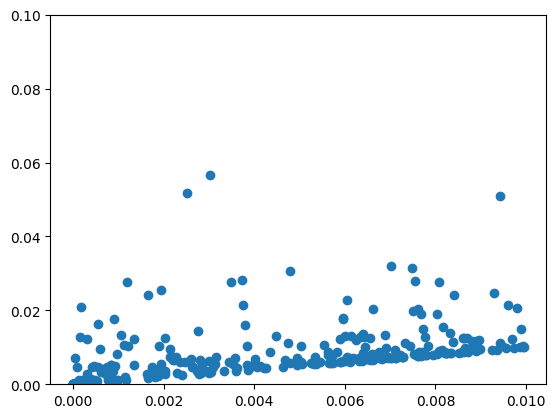

In [22]:
import matplotlib.pyplot as plt

plt.plot(AE_nu_diff_lst, RELA_nu_lst, 'o')
plt.ylim(0, 0.1)